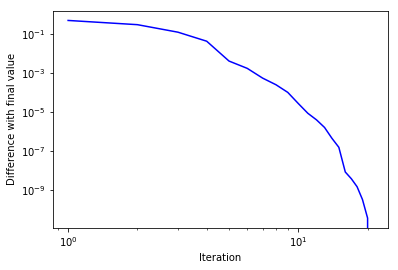

Calculated:
Function:  20
Gradient:  20
Gessian:  20
Point:  [1.74656131e-11 1.00000000e+00]
Value:  2.2145699244543664


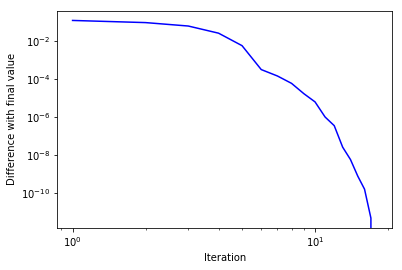

Calculated:
Function:  17
Gradient:  17
Gessian:  17
Point:  [2.11637450e-01 4.33684155e-02 1.26891557e-01 9.42136449e-02
 4.82046305e-02 3.85489237e-02 1.20743278e-01 1.63784214e-01
 1.52607887e-01 4.41397517e-12]
Value:  0.9988445598953184


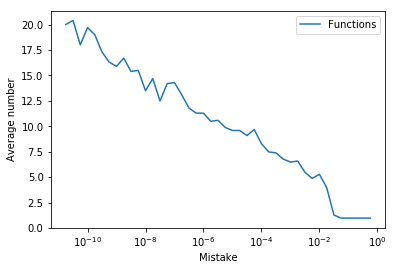

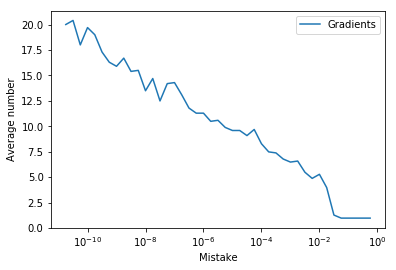

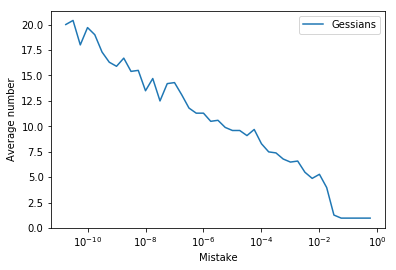

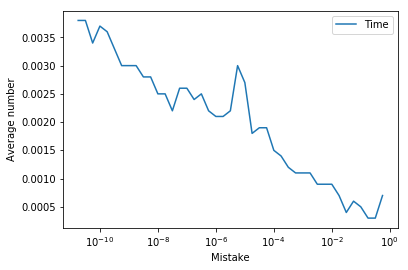

In [3]:
import numpy as np
import scipy.stats as st
import copy
import math
import matplotlib
import time
from matplotlib import pyplot as plt

class Oracle:
    def __init__(self, p, pi):
        assert(p.shape[1] == pi.shape[0])
        self.__pi = copy.copy(pi)
        self.__p = copy.copy(p)
        self.__calc = 0
        self.__grad = 0
        self.__gess = 0
    
    def Calculate(self, x):
        self.__calc += 1
        return np.sum(self.__pi * np.log(self.__p.T @ x))
    
    def CalculateGradient(self, x):
        self.__grad += 1
        return self.__p @ (self.__pi * (self.__p.T @ x)**(-1))
    
    def CalculateGessian(self, x):
        self.__gess += 1
        return -self.__p @ np.diagflat(self.__pi * (self.__p.T @ x)**(-2)) @ self.__p.T
    
    @property
    def Calculated(self):
        return self.__calc;
    
    @property
    def CalculatedGradients(self):
        return self.__grad;
    
    @property
    def CalculatedGessians(self):
        return self.__gess;
    
def Normalization(A):
    assert(A.shape[0] == A.shape[1])
    return A - np.eye(A.shape[0])
    
class NewtonIterator:
    def __init__(self, begin, oracle, projector, step_choser, priority, checker, normalizator):
        self.__point = copy.copy(begin)
        self.__oracle = copy.copy(oracle)
        self.__projector = copy.copy(projector)
        self.__step_choser = copy.copy(step_choser)
        self.__priority = copy.copy(priority)
        self.__checker = copy.copy(checker)
        self.__normalizator = copy.copy(normalizator)
        self.__step = 1.0
        self.__value = oracle.Calculate(begin)
    def MakeStep(self):
        gess = self.__oracle.CalculateGessian(self.__point)
        grad = self.__oracle.CalculateGradient(self.__point)
        gess = np.linalg.inv(self.__normalizator(gess))
        direction = self.__projector(gess @ grad)
        old_value = self.__value
        improve = False
        while (not improve):
            new_point = self.__point - self.__step * direction
            if (not self.__checker(new_point)):
                self.__step = self.__step_choser(self.__step, False)
            else:
                new_value = self.__oracle.Calculate(new_point)
                improve = self.__priority(new_value, old_value)
                self.__step = self.__step_choser(self.__step, improve)
                if (improve):
                    self.__point = new_point
                    self.__value = new_value
    
    @property
    def Oracle(self):
        return self.__oracle
    
    @property
    def Value(self):
        return self.__value
    
    @property
    def Point(self):
        return self.__point
    
def Projector(x):
    y = x - np.sum(x) * np.ones(x.size) / x.size
    return y

def StepChoser(prev, success):
    next = prev
    if success:
        if (next < 1.0):
            next *= 2.0
            if (next > 1):
                next = 1.0
    else:
        next /= 2.0
    return next 

def Checker(x):
    if (not np.all(x > 0)):
        return False
    else:
        return True
    
def PriorityMax(x, y):
    return x > y
    
class NewtonSpecializatorMax(NewtonIterator):
    def __init__(self, begin, p, pi):
        NewtonIterator.__init__(self, begin, Oracle(p, pi), Projector, StepChoser, PriorityMax, Checker, Normalization)
        
def FindMax(begin, p, pi, mistake):
    iterator = NewtonSpecializatorMax(begin, p, pi)
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    return iterator

def GraphicMax(begin, p, pi, mistake):
    iterator = NewtonSpecializatorMax(begin, p, pi)
    iterations = np.array([iterator.Value])
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        iterations = np.append(iterations, iterator.Value)
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    plt.xlabel("Iteration")
    plt.ylabel("Difference with final value")
    plt.loglog(np.arange(iterations.size) + 1, np.abs(prev - iterations), "b-")
    plt.show()
    return iterator

def IterationsMistake(n, m, mistake):
    N = 10
    iterations_calc = np.zeros(0)
    iterations_grad = np.zeros(0)
    iterations_gess = np.zeros(0)
    iterations_time = np.zeros(0)
    for diff in mistake:
        calc = 0
        grad = 0
        gess = 0
        spend = 0.
        for i in range(N):
            p = np.abs(np.random.rand(n, m) * 5)
            pi = np.abs(np.random.rand(m))
            pi /= np.sum(pi)
            begin = np.ones(n) / n
            begin_time = time.time()
            iterator = FindMax(begin, p, pi, diff)
            end_time = time.time()
            calc += iterator.Oracle.Calculated
            grad += iterator.Oracle.CalculatedGradients
            gess += iterator.Oracle.CalculatedGessians
            spend += end_time - begin_time
        calc /= N
        grad /= N
        gess /= N
        spend /= N
        iterations_calc = np.append(iterations_calc, calc)
        iterations_grad = np.append(iterations_grad, grad)
        iterations_gess = np.append(iterations_gess, gess)
        iterations_time = np.append(iterations_time, spend)
    plt.xlabel("Mistake")
    plt.ylabel("Average number")
    plt.semilogx(mistake, iterations_grad)
    plt.legend(["Functions"])
    plt.show()
    plt.xlabel("Mistake")
    plt.ylabel("Average number")
    plt.semilogx(mistake, iterations_grad)
    plt.legend(["Gradients"])
    plt.show()
    plt.xlabel("Mistake")
    plt.ylabel("Average number")
    plt.semilogx(mistake, iterations_gess)
    plt.legend(["Gessians"])
    plt.show()
    plt.xlabel("Mistake")
    plt.ylabel("Average number")
    plt.semilogx(mistake, iterations_time)
    plt.legend(["Time"])
    plt.show()
    
def Test():
    n = 2
    m = 3
    p = np.array([[1, 2, 3], [10, 9, 8]])
    pi = np.array([0.5, 0.2, 0.3])
    begin = np.ones(n) / n
    iterator = GraphicMax(begin, p, pi, 10**(-10))
    print("Calculated:")
    print("Function: ", iterator.Oracle.Calculated)
    print("Gradient: ", iterator.Oracle.CalculatedGradients)
    print("Gessian: ", iterator.Oracle.CalculatedGessians)
    print("Point: ", iterator.Point)
    print("Value: ", iterator.Value)
    
def RandomTest():
    n = 10
    m = 10
    p = np.abs(np.random.rand(n, m) * 5)
    pi = np.abs(np.random.rand(m))
    pi /= np.sum(pi)
    begin = np.ones(n) / n
    iterator = GraphicMax(begin, p, pi, 10**(-10))
    print("Calculated:")
    print("Function: ", iterator.Oracle.Calculated)
    print("Gradient: ", iterator.Oracle.CalculatedGradients)
    print("Gessian: ", iterator.Oracle.CalculatedGessians)
    print("Point: ", iterator.Point)
    print("Value: ", iterator.Value)
    
Test()
RandomTest()
n = 10
m = 10
IterationsMistake(n, m, 10**(-1 * np.arange(1, 44) / 4.0))

In [11]:
x = np.array([2.0, 0.0])

np.all(x > 1)

False